# Analyzing/Predicting Sentiment From Amazon Reviews

For this exercise, let's go back to the sentiment analysis we did earlier in the course - specifically, the Amazon reviews dataset.

It's important to start with a clear goal in mind. In this case, we'd like to determine if we can __predict whether a review is positive or negative based on the language in the review.__

We're going to tackle this problem with Spark - so you'll need to apply the principles you've learned thus far in the context of Spark.

Some tips to help you get started:

1. Don't forget to install Java, Spark, Findspark and PySpark. You may also need to re-mount your drive to Colab. You can use the codes from the previous assignment for this purpose.
2. Pyspark always needs to point at a running Spark instance. You can do that using a `SparkContext`.
3. We're working in batch mode, so you'll need to load an entire file into memory in order to run any models you build.
4. Spark likes to execute models in a pipeline, so remember that when the time comes to set up your model.
5. Spark's machine learning algorithms expect numeric variables.

In [1]:
# Install Java, Spark, Findspark and PySpark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

!pip install -q findspark
!pip install pyspark

# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

    100% |████████████████████████████████| 213.4MB 87kB/s 
    100% |████████████████████████████████| 204kB 30.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/cd/54/c2/abfcc942eddeaa7101228ebd6127a30dbdf903c72db4235b23
Successfully built pyspark
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Tokenizer, Word2Vec

# these imports are how we build and manage our data science processes: 
# cleaning data, preparing a model, executing the model, and evaluating the model.
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from matplotlib import pyplot as plt
import numpy as np
import functools
%matplotlib inline

In [0]:
# we use a set of constants for clarity and simplicity in managing the notebook.
# this allows you to refer back to this cell at any time 
# if you need to either confirm or modify any of these values.

DATA_NAME = "/content/gdrive/My Drive/Colab Datasets/AmznInstantVideo.json"
APP_NAME = "Sentiment Analysis with Amazon Reviews Exercise"
SPARK_URL = "local[*]"
RANDOM_SEED = 141107
TRAINING_DATA_RATIO = 0.8
RF_NUM_TREES = 10
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

The first thing we always do is create a `SparkContext`, and then immediately afterward create a `sqlContext` to be able to load and manipulate an RDD/dataframe.

In [0]:
sc = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()
sqlContext = SQLContext(sc)

Now that we've connected to Spark and have a sqlContext ready, it's time to load our data. 

We assume that you've already checked over some of the data, understand its type, and expected values/lengths before you get here.

Luckily this is a simple exercise - this is a JSON file and all we need to do is load it into a dataframe.

In [0]:
amznInstantVideo = sqlContext.read.json(DATA_NAME)

Let's check the shape of the dataset, and review the schema so we see what we're dealing with.

In [6]:
print(f"Dataset shape is {amznInstantVideo.count():d} rows by {len(amznInstantVideo.columns):d} columns.")

Dataset shape is 37121 rows by 9 columns.


In [7]:
amznInstantVideo.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



Our schema shows that there is hope for our problem. Specifically, there are two columns that look interesting, and potentially a third:

* __overall__: this looks like where we're keeping the starred review - on a scale of 1 to 5. We can make a decision on how we want to handle this in our model.
* __reviewText__: This looks like it's the actual text of the review - we need to figure out from this whether or not it is positive or negative.
* __summary__: This could also be helpful, but we need to understand what it is.

Based on this cursory review of the dataset, we can see that we should be able to prepare this data such that we can use a classifier to model the sentiment (positive/negative) of the dataset.

There are two data preparation steps we'll need to do before we run our model:
1. Decide whether to recode our __overall__ column into a more limited variable - either simply __positive/negative__ or __positive/neutral/negative__
2. Convert the text of each review into a numerical vector. Pyspark offers a number of methods to do this - we'll use __Word2Vec__

Before we get going on our data preparation, let's take a look at the columns we mentioned above.

To perform a SQL query on a dataframe, we need to create a `tempTable`.

In [0]:
amznInstantVideo.registerTempTable('reviews')

In [9]:
sqlContext.sql("select overall, count(overall) as reviewCount from reviews group by overall order by overall desc").show()

+-------+-----------+
|overall|reviewCount|
+-------+-----------+
|    5.0|      20888|
|    4.0|       8445|
|    3.0|       4185|
|    2.0|       1885|
|    1.0|       1718|
+-------+-----------+



We see that most of the reviews are 5-star - so we certainly should recode. For our purposes, we can get closer to a balanced dataset if we recode to >3 is positive, <= 3 is negative. 

It's a bit of a stretch but a decent first pass.

(Later, if you want to improve your classifier's performance, you could apply a resampling method to help balance the dataset).

Let's recode the overall score to __positive__ or __negative__
* __Positive__: overall > 3
* __Negative__: overall <= 3

The easiest path to recoding the data in this fashion is to create a new column, from a User Defined Function.

In [0]:
udf = UserDefinedFunction(lambda x: 1 if x > 3.0 else -1, IntegerType())

amznInstantVideo = amznInstantVideo.withColumn("overall_recode",udf(amznInstantVideo.overall))

This time let's just make a plot of the two labels - so we can see the imbalance.

([<matplotlib.axis.XTick at 0x7fc3d2b79780>,
 <a list of 2 Text xticklabel objects>)

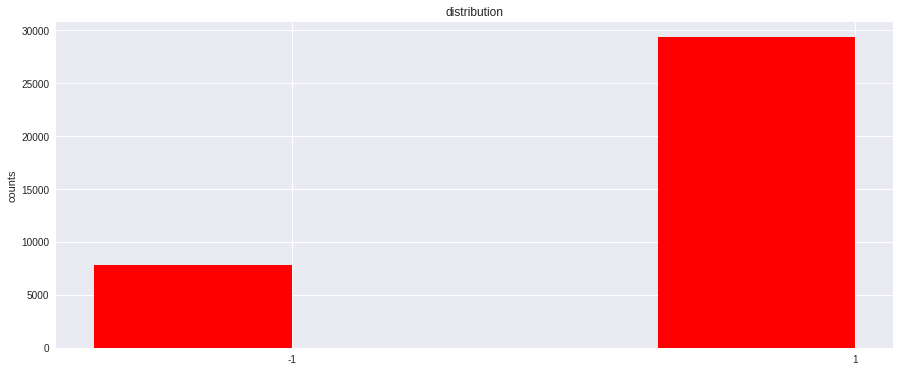

In [11]:
plt.rcParams['figure.figsize'] = (15, 6)
 
statuses = amznInstantVideo.groupBy('overall_recode').count().collect()

categories = [i[0] for i in statuses]
counts = [i[1] for i in statuses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('distribution')
plt.xticks(ind + width/2., categories)

Now it's time to look at the text and encode it into vectors.

First, let's take a look at the relevant columns.

In [12]:
amznInstantVideo.select("overall", "overall_recode", "summary", "reviewText").show(10)

+-------+--------------+--------------------+--------------------+
|overall|overall_recode|             summary|          reviewText|
+-------+--------------+--------------------+--------------------+
|    2.0|            -1|A little bit bori...|I had big expecta...|
|    5.0|             1|Excellent Grown U...|I highly recommen...|
|    1.0|            -1|Way too boring fo...|This one is a rea...|
|    4.0|             1|Robson Green is m...|Mysteries are int...|
|    5.0|             1|Robson green and ...|This show always ...|
|    5.0|             1|I purchased the s...|I discovered this...|
|    3.0|            -1|It takes up your ...|It beats watching...|
|    3.0|            -1|A reasonable way ...|There are many ep...|
|    5.0|             1|           kansas001|This is the best ...|
|    3.0|            -1| Entertaining Comedy|Not bad.  Didn't ...|
+-------+--------------+--------------------+--------------------+
only showing top 10 rows



For the start of this exercise we'll use only the `reviewText` column; later we could even merge the `summary` and `reviewText` to see if it improves the performance of the classifier.

In [0]:
tokenizer = Tokenizer(inputCol="reviewText", outputCol="tokenized_text").transform(amznInstantVideo)

word2Vec = Word2Vec(vectorSize=300, seed=42, inputCol="tokenized_text", outputCol="w2v_vector").fit(tokenizer)

w2vdf=word2Vec.transform(tokenizer)

In [14]:
w2vdf.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- overall_recode: integer (nullable = true)
 |-- tokenized_text: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- w2v_vector: vector (nullable = true)



In [15]:
w2vdf.select("overall_recode", "reviewText", "tokenized_text", "w2v_vector").show(10)

+--------------+--------------------+--------------------+--------------------+
|overall_recode|          reviewText|      tokenized_text|          w2v_vector|
+--------------+--------------------+--------------------+--------------------+
|            -1|I had big expecta...|[i, had, big, exp...|[-0.0386027075583...|
|             1|I highly recommen...|[i, highly, recom...|[0.03085500549059...|
|            -1|This one is a rea...|[this, one, is, a...|[0.00350296836292...|
|             1|Mysteries are int...|[mysteries, are, ...|[0.00306359282694...|
|             1|This show always ...|[this, show, alwa...|[0.00180407294192...|
|             1|I discovered this...|[i, discovered, t...|[0.00200728614325...|
|            -1|It beats watching...|[it, beats, watch...|[-0.0376871883403...|
|            -1|There are many ep...|[there, are, many...|[-0.0319872667490...|
|             1|This is the best ...|[this, is, the, b...|[-0.0174919149108...|
|            -1|Not bad.  Didn't ...|[no

Since we have everything in numeric format, let's start with our old standby, the __random forest__. You can choose other classifiers to see how they perform, and even chain them together and use their collective predictions in an ensemble to improve model performance.

Important - note that your data is now in the `w2vdf` object - not the `amznInstantVideo` object.

In [0]:
# Build the training indexers/split data/classifier
# first we'll generate a labelIndexer
labelIndexer = StringIndexer(inputCol="overall_recode", outputCol="indexedLabel").fit(w2vdf)

# now generate the indexed feature vector.
featureIndexer = VectorIndexer(inputCol="w2v_vector", outputCol="indexedFeatures", maxCategories=4).fit(w2vdf)
    
# Split the data into training and validation sets (30% held out for testing)
(trainingData, testData) = w2vdf.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])

In [0]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

In [18]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.20445
Accuracy = 0.79555


We didn't do so well... but that's typical in data science work.

Here's where you can go from here:
1. Think about resampling the overall dataset to better balance positive and negative reviews.
2. Use a different method to tokenize and convert the text to numeric (TF/IDF, etc).
3. Adjust the parameters of your classifier.
